In [37]:
import numpy as np
import random
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind, mannwhitneyu
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder


In [16]:
# random.seed(17194376)
rand_state = random.seed(17194376)

df = pd.read_csv('spotify52kData.csv')#, error_bad_lines=False
basic_stats = df.describe()
missing_values = df.isna().sum()
data_types = df.dtypes
print(basic_stats, missing_values, data_types)

         songNumber    popularity      duration  danceability        energy  \
count  52000.000000  52000.000000  5.200000e+04  52000.000000  52000.000000   
mean   25999.500000     33.115923  2.302998e+05      0.563900      0.668259   
std    15011.251336     21.743697  1.176823e+05      0.176573      0.249585   
min        0.000000      0.000000  1.745300e+04      0.000000      0.000020   
25%    12999.750000     18.000000  1.739470e+05      0.447000      0.508000   
50%    25999.500000     33.000000  2.135460e+05      0.574000      0.717000   
75%    38999.250000     50.000000  2.651962e+05      0.696000      0.877000   
max    51999.000000    100.000000  4.789026e+06      0.983000      1.000000   

                key      loudness          mode   speechiness  acousticness  \
count  52000.000000  52000.000000  52000.000000  52000.000000  52000.000000   
mean       5.348442     -7.972804      0.622904      0.095864      0.271442   
std        3.562600      4.919127      0.484664    

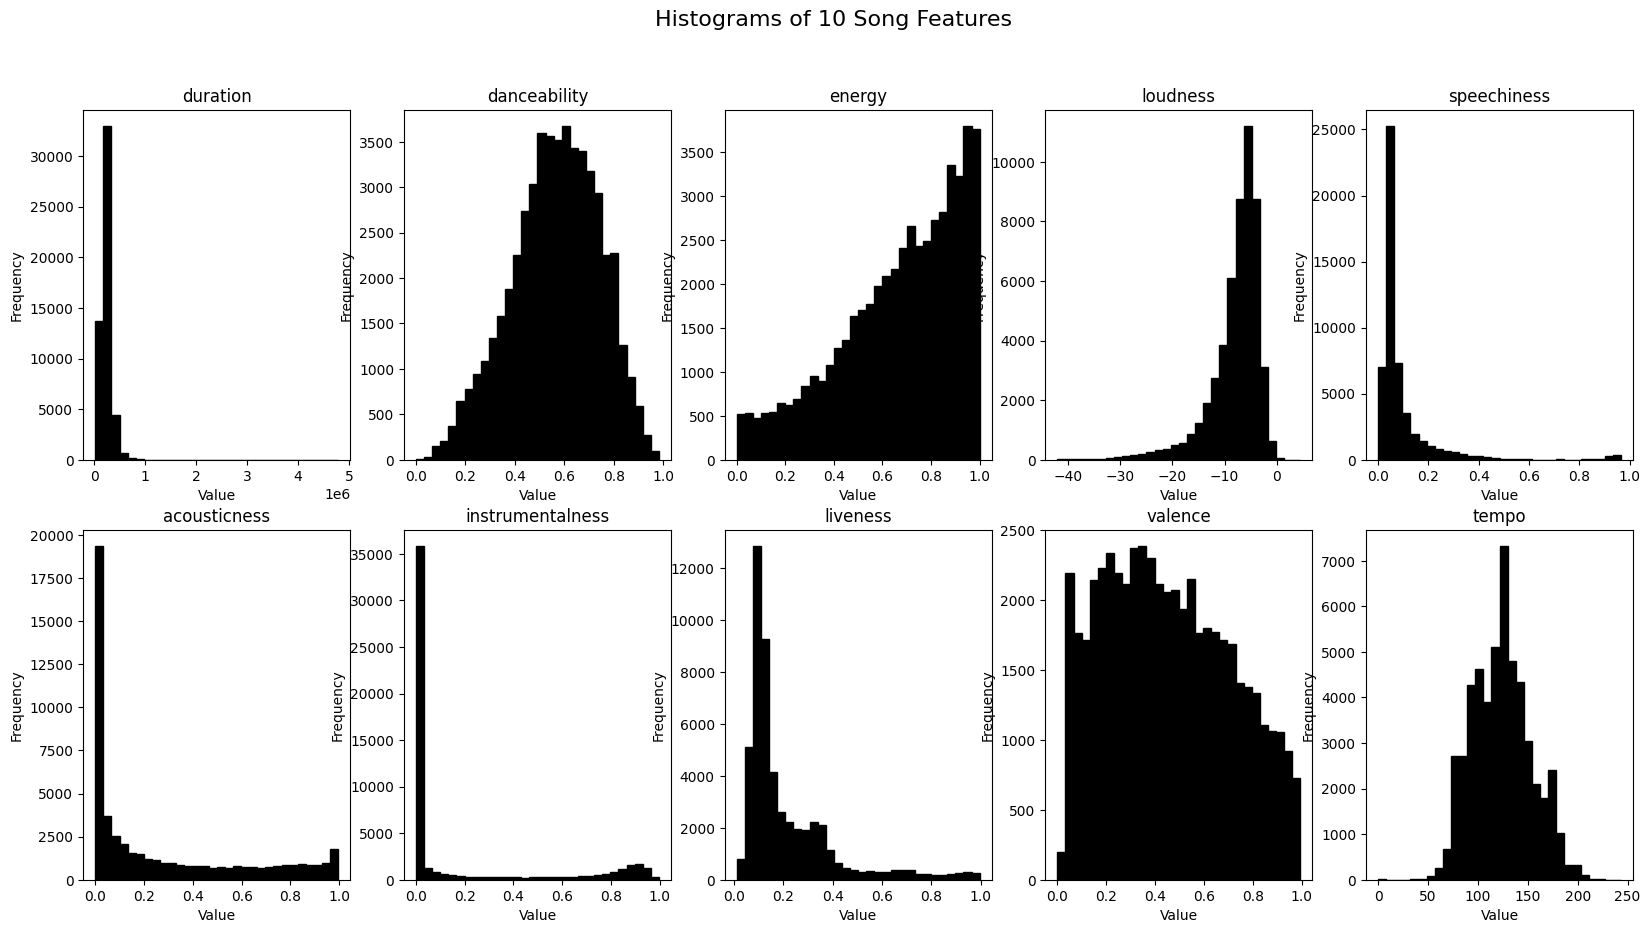

In [17]:
# feature distribution
features = ['duration', 'danceability', 'energy', 'loudness', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']


fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
fig.suptitle('Histograms of 10 Song Features', fontsize=16)

for ii, feature in enumerate(features):
    ax = axes[ii//5, ii%5]
    ax.hist(df[feature], bins=30, color='black', edgecolor='black')
    ax.set_title(feature)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

plt.show()

### Relationship between song length and popularity of a song?

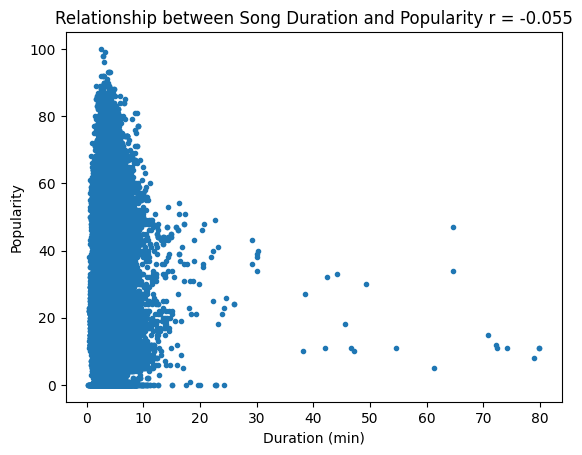

In [18]:
duration_min = df['duration'] / (1000*60)
popularity = df['popularity']

plt.plot(duration_min, popularity,'o',markersize=3)
rQ1 = np.corrcoef(duration_min, popularity)
plt.title('Relationship between Song Duration and Popularity r = {:.3f}'.format(rQ1[0,1]))
plt.xlabel('Duration (min)')
plt.ylabel('Popularity')
plt.show()

### Are explicitly rated songs more popular than songs that are not explicit?

In [10]:
explicit_songs = df[df['explicit'] == 1]['popularity']
non_explicit_songs = df[df['explicit'] == 0]['popularity']
stat, p = mannwhitneyu(explicit_songs, non_explicit_songs)
print(f'Mann-Whitney U test statistic: {stat}, p-value: {p}')

Mann-Whitney U test statistic: 139361273.5, p-value: 3.0679199339114678e-19


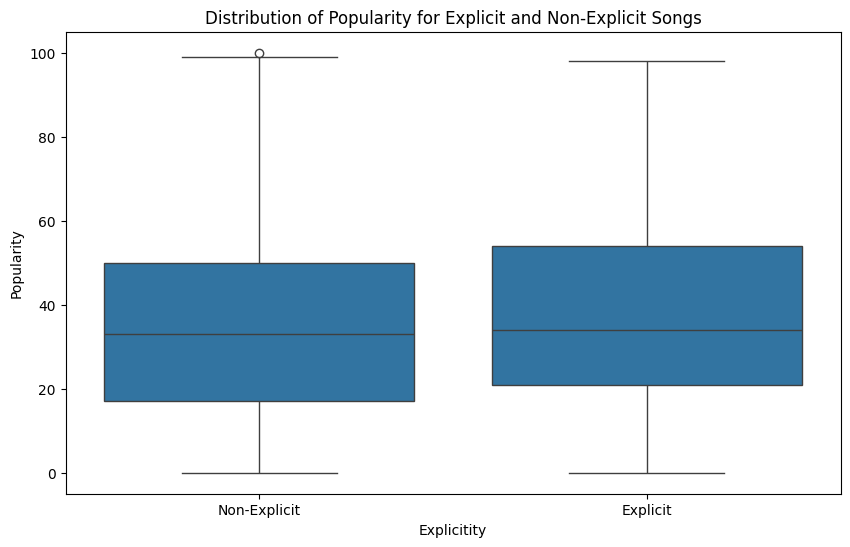

Explicit:  35.81311416830445
Non-Explicit:  32.790595435639936


In [19]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='explicit', y='popularity', data=df)
plt.title('Distribution of Popularity for Explicit and Non-Explicit Songs')
plt.xlabel('Explicitity')
plt.ylabel('Popularity')
plt.xticks(ticks=[0, 1], labels=['Non-Explicit', 'Explicit'])
plt.show()
mean_explicit = df[df['explicit'] == True]['popularity'].mean()
mean_non_explicit = df[df['explicit'] == False]['popularity'].mean()
print("Explicit: ", mean_explicit)
print("Non-Explicit: ", mean_non_explicit)

### Are songs in major key more popular than songs in minor key?

In [15]:
major_popularity = df[df['mode'] == 1]['popularity']
minor_popularity = df[df['mode'] == 0]['popularity']
stat, p = mannwhitneyu(major_popularity, minor_popularity)
print(f'Mann-Whitney U test statistic: {stat}, p-value: {p}')

Mann-Whitney U test statistic: 309702373.0, p-value: 2.0175287554899416e-06


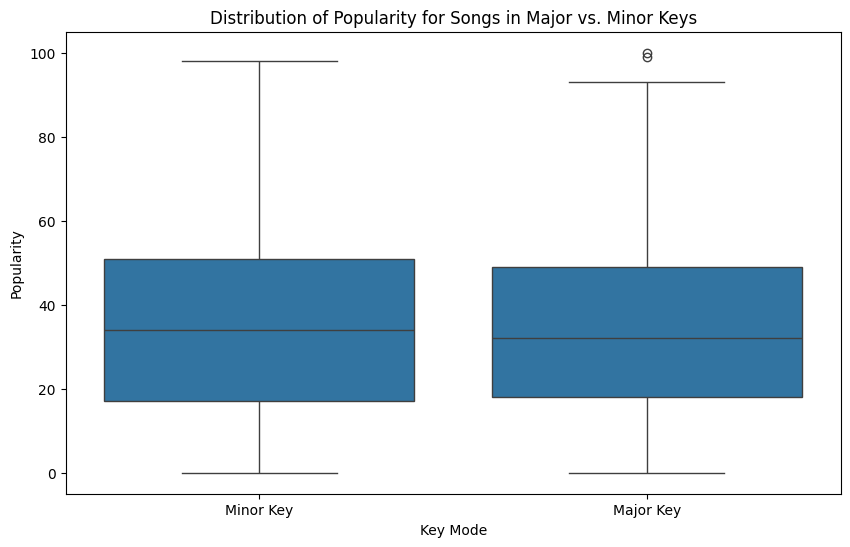

Major:  32.75838967614461
Minor:  33.70651231577337


In [20]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='mode', y='popularity', data=df)
plt.title('Distribution of Popularity for Songs in Major vs. Minor Keys')
plt.xlabel('Key Mode')
plt.ylabel('Popularity')
plt.xticks(ticks=[0, 1], labels=['Minor Key', 'Major Key'])
plt.show()
mean_major = df[df['mode'] == 1]['popularity'].mean()
mean_minor = df[df['mode'] == 0]['popularity'].mean()

print("Major: ", mean_major)
print("Minor: ", mean_minor)

### Loudness & Energy

Correlation Coefficient between Energy and Loudness: 0.774880829185019


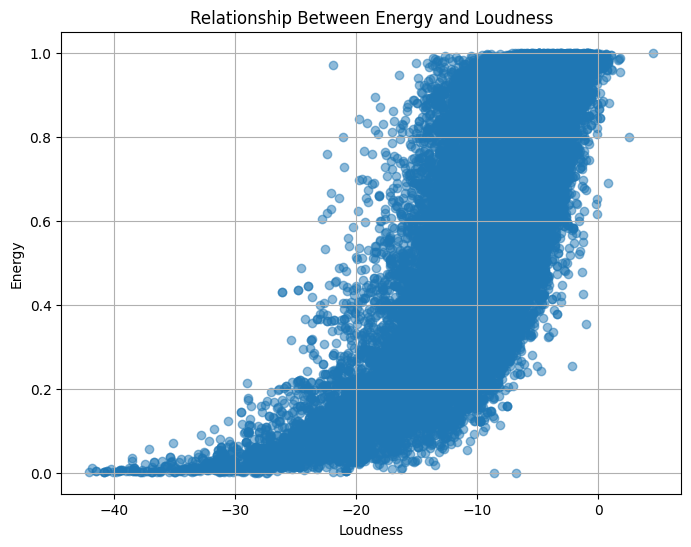

In [25]:
correlation_coefficient = df['energy'].corr(df['loudness'])
print("Correlation Coefficient between Energy and Loudness:", correlation_coefficient)
energy = df['energy']
loudness = df['loudness']
plt.figure(figsize=(8, 6))
plt.scatter(loudness, energy, alpha=0.5)
plt.title('Relationship Between Energy and Loudness')
plt.xlabel('Loudness')
plt.ylabel('Energy')
plt.grid(True)
plt.show()

### Each feature vs Popularity

In [27]:
model_results = []

for feature in features:
    model = LinearRegression()

    X = df[feature].values.reshape(-1, 1)
    y = df['popularity']
    model.fit(X, y)
    predictions = model.predict(X)
    mse = mean_squared_error(y, predictions)
    r_squared = r2_score(y, predictions)
    model_results.append({
        'Feature': feature,
        'RMSE': np.sqrt(mse),
        'R^2': r_squared
    })

model_results_df = pd.DataFrame(model_results)
model_results_df.sort_values(by='R^2', ascending=False, inplace=True)
model_results_df.reset_index(drop=True, inplace=True)
model_results_df

,Feature,RMSE,R^2
0,instrumentalness,21.513783,0.021017
1,loudness,21.704039,0.003625
2,energy,21.709459,0.003128
3,duration,21.710992,0.002987
4,speechiness,21.717865,0.002355
5,liveness,21.722577,0.001922
6,danceability,21.728472,0.001381
7,valence,21.729574,0.001279
8,acousticness,21.736005,0.000688
9,tempo,21.743412,0.000007


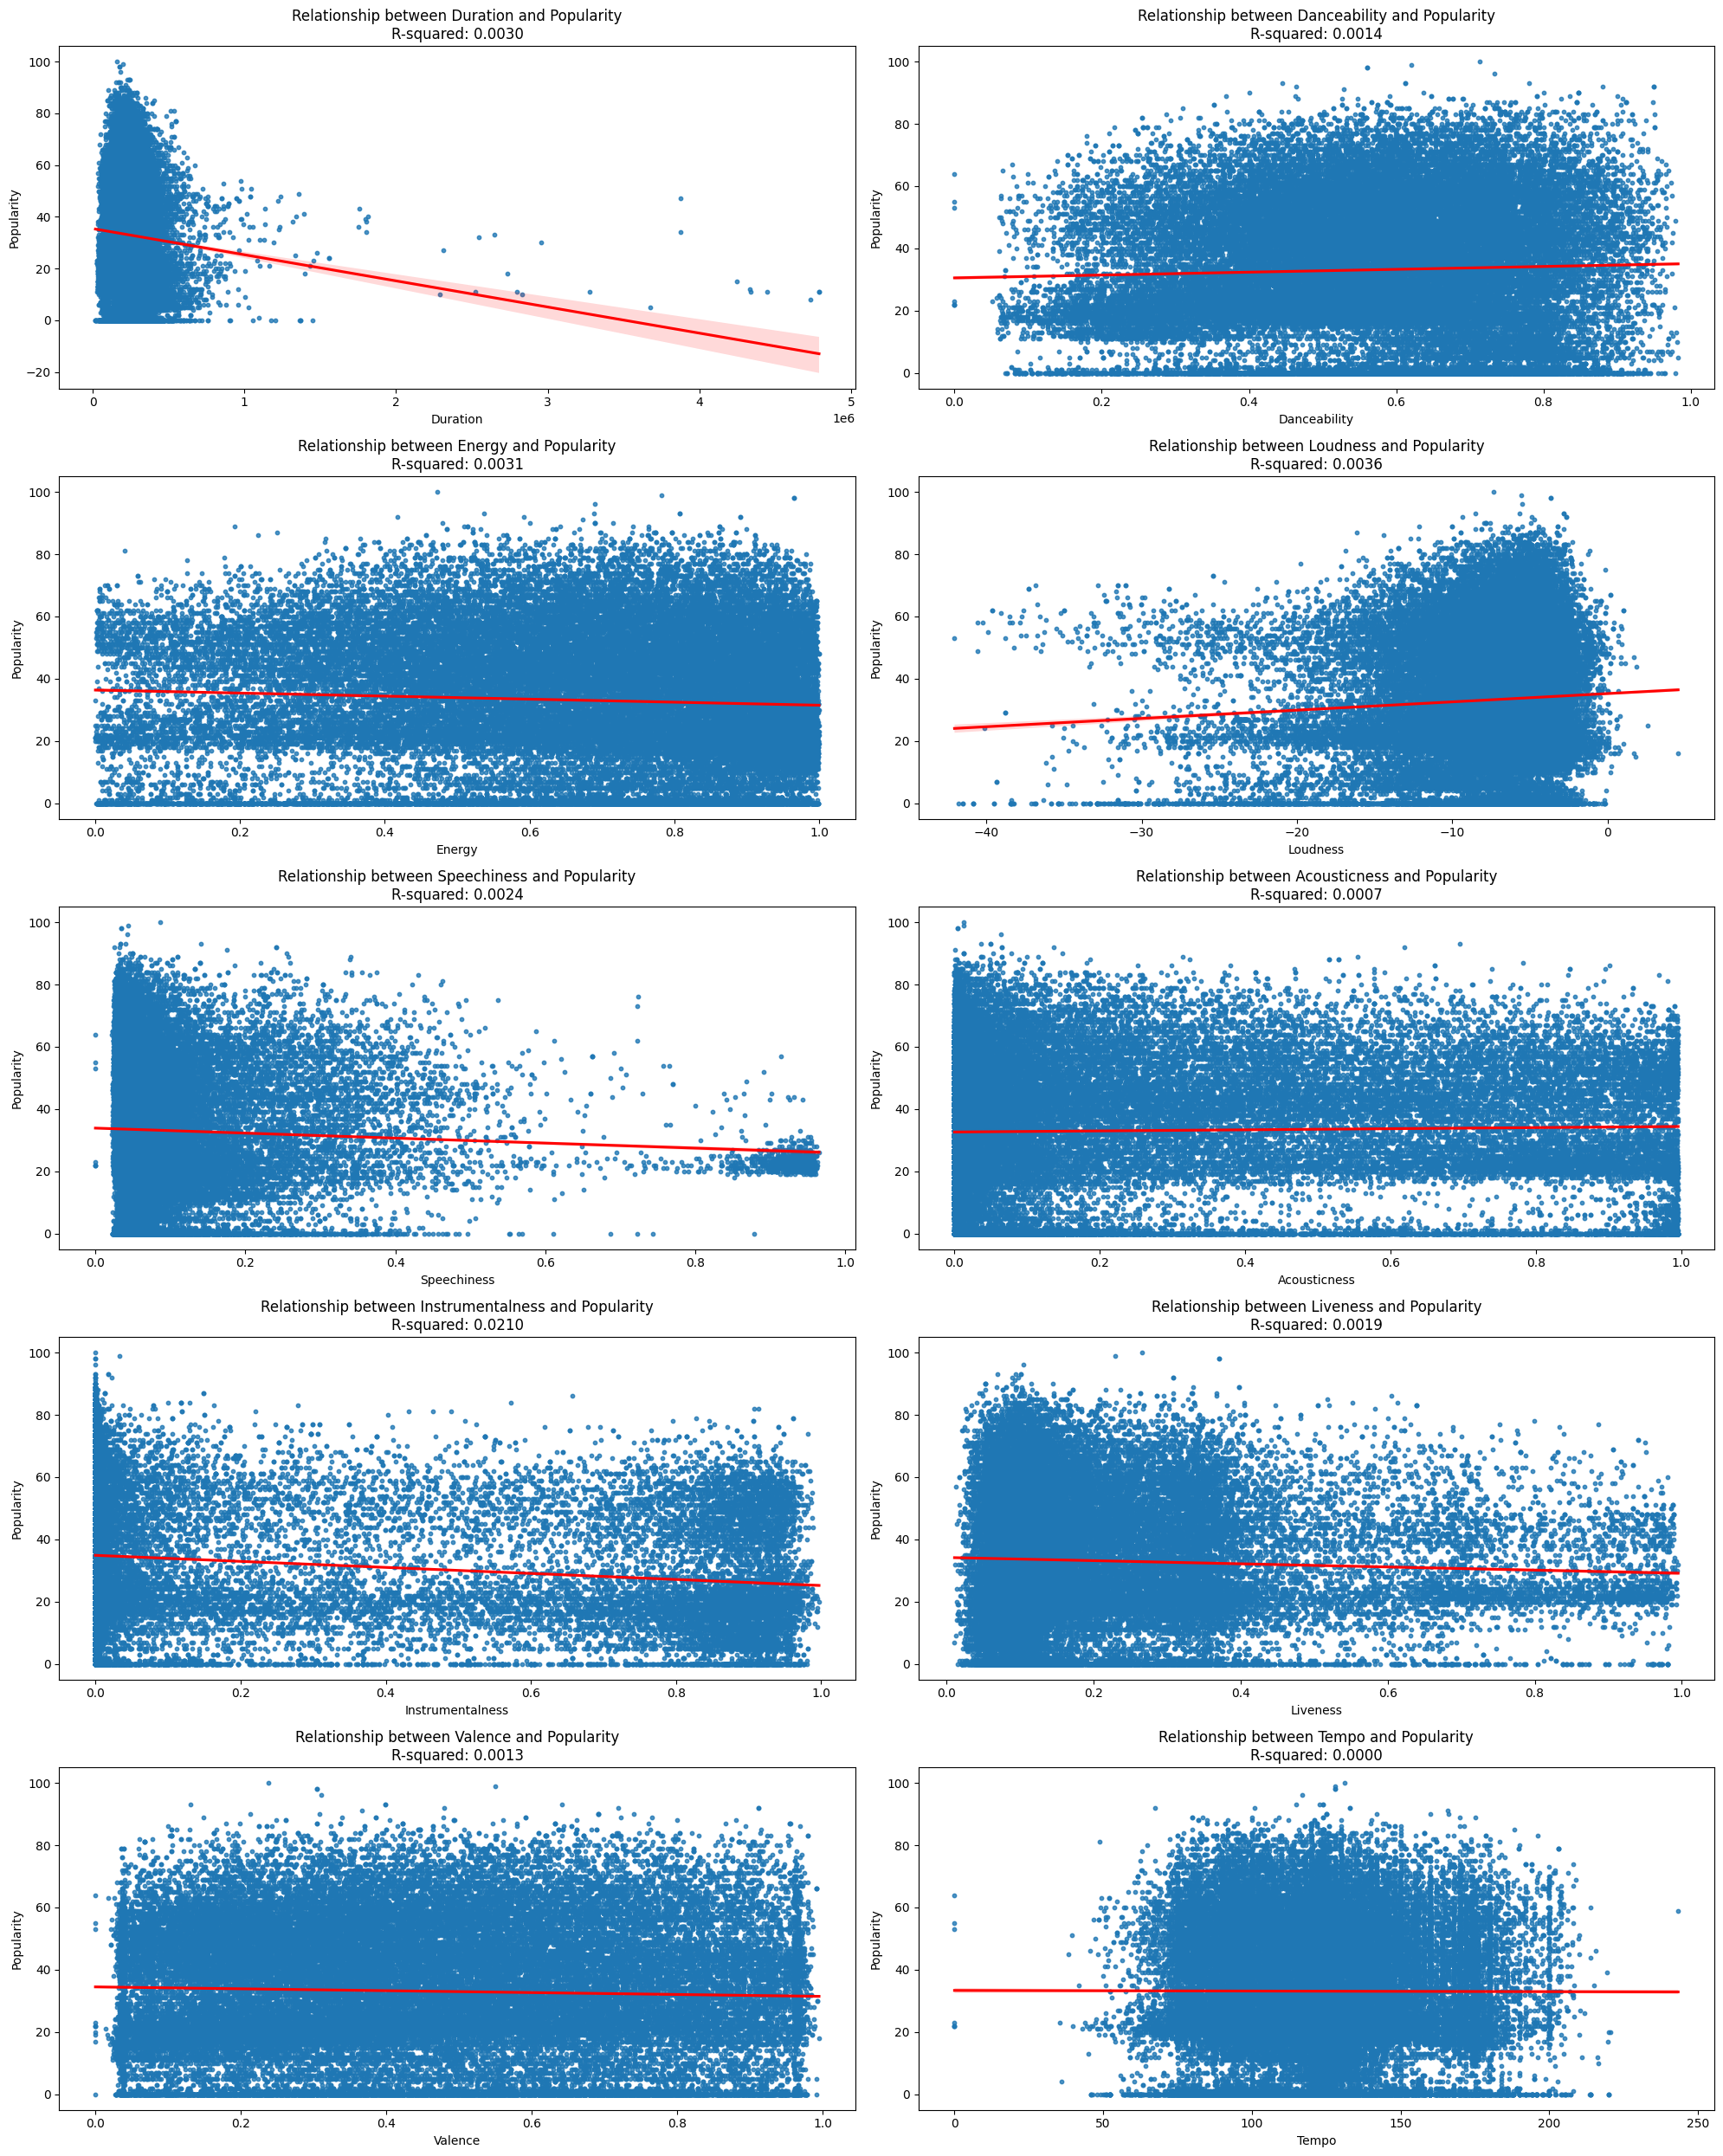

instrumentalness : 0.021016959224749443


In [31]:
r2_scores = {}
fig, axes = plt.subplots(5, 2, figsize=(20, 25))
axes = axes.flatten()
for i, feature in enumerate(features):
    X = df[feature].values.reshape(-1, 1)
    y = df['popularity'].values
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    r2_scores[feature] = r2_score(y, y_pred)
    sns.regplot(x=df[feature], y=y, ax=axes[i], scatter_kws={'s': 10}, line_kws={"color": "red"})
    axes[i].set_title(f'Relationship between {feature.capitalize()} and Popularity\nR-squared: {r2_scores[feature]:.4f}')
    axes[i].set_xlabel(feature.capitalize())
    axes[i].set_ylabel('Popularity')
plt.tight_layout()
plt.show()
best_feature = max(r2_scores, key=r2_scores.get)
best_r2 = r2_scores[best_feature]
print(best_feature, ':', best_r2)

### All features vs Popularity

r^2 for all features 0.047679614286711636


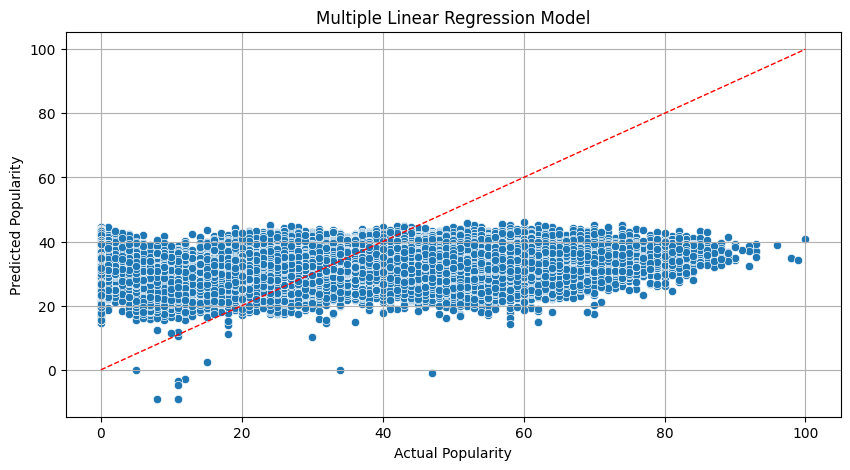

In [32]:
X_all_features = df[features]
y = df['popularity']
model_all_features = LinearRegression()
model_all_features.fit(X_all_features, y)
y_pred_all = model_all_features.predict(X_all_features)
r2_all_features = r2_score(y, y_pred_all)
print("r^2 for all features", r2_all_features)
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y, y=y_pred_all, alpha=1)
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r', linewidth=1)
plt.title('Multiple Linear Regression Model')
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
plt.grid(True)
plt.show()

### PCA

In [33]:
scaler_model = StandardScaler()
scaled_features = scaler_model.fit_transform(df[features])

pca_transformation = PCA(n_components=len(features))
pca_transformation.fit(scaled_features)

variance_ratio_per_component = pca_transformation.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(variance_ratio_per_component)

components_count_95 = np.argmax(cumulative_variance_ratio >= 0.95) + 1

cluster_inertias = []
for cluster_count in tqdm(range(1, 11)):
    cluster_model = KMeans(n_clusters=cluster_count, random_state=42)
    cluster_model.fit(scaled_features)
    cluster_inertias.append(cluster_model.inertia_)

elbow_point_locator = KneeLocator(range(1, 11), cluster_inertias, curve='convex', direction='decreasing')

analysis_results = {
    'variance_ratio_each_component': variance_ratio_per_component.tolist(),
    'cumulative_variance_ratio': cumulative_variance_ratio.tolist(),
    'components_for_95_percent_variance': components_count_95,
    'recommended_cluster_count': elbow_point_locator.elbow
}

print(analysis_results)
print('Cumulative Variance Ratios:', analysis_results['cumulative_variance_ratio'])
print('Components for 95% Variance:', analysis_results['components_for_95_percent_variance'])
print('Recommended Number of Clusters:', analysis_results['recommended_cluster_count'])

  0%|                                                    | 0/10 [00:00<?, ?it/s]/Users/zijianju/anaconda3/lib/python3.10/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.09it/s]

{'variance_ratio_each_component': [0.2733880965774013, 0.16173597602451983, 0.1384578696777999, 0.09795879848864, 0.08752093955803025, 0.08148307256834171, 0.06782685871144352, 0.04715720330909468, 0.031313366900924636, 0.01315781818380408], 'cumulative_variance_ratio': [0.2733880965774013, 0.43512407260192115, 0.573581942279721, 0.671540740768361, 0.7590616803263912, 0.840544752894733, 0.9083716116061765, 0.9555288149152712, 0.9868421818161959, 1.0], 'components_for_95_percent_variance': 8, 'recommended_cluster_count': 4}
Cumulative Variance Ratios: [0.2733880965774013, 0.43512407260192115, 0.573581942279721, 0.671540740768361, 0.7590616803263912, 0.840544752894733, 0.9083716116061765, 0.9555288149152712, 0.9868421818161959, 1.0]
Components for 95% Variance: 8
Recommended Number of Clusters: 4


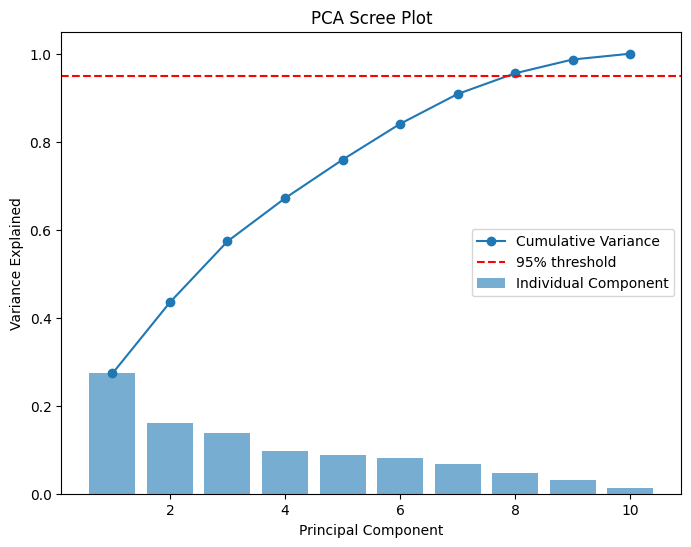

In [44]:
X = df[["duration","danceability","energy","loudness","speechiness",
        "acousticness","instrumentalness","liveness","valence","tempo"]].values

X_std = StandardScaler().fit_transform(X)
pca = PCA().fit(X_std)

explained = pca.explained_variance_ratio_
cum_explained = np.cumsum(explained)

plt.figure(figsize=(8,6))
plt.plot(range(1,len(explained)+1), cum_explained, marker='o', label='Cumulative Variance')
plt.bar(range(1,len(explained)+1), explained, alpha=0.6, label='Individual Component')
plt.axhline(0.95, color='red', linestyle='--', label='95% threshold')
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained")
plt.title("PCA Scree Plot")
plt.legend()
plt.show()

In [46]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(len(features))],
    index=features
)
print(loadings)

                       PC1       PC2       PC3       PC4       PC5       PC6  \
duration          0.028965 -0.292382 -0.072764  0.825716  0.260080 -0.382633   
danceability      0.154893  0.568718 -0.187694  0.316386  0.132779  0.226342   
energy            0.536818 -0.191436  0.054129  0.026530 -0.090295  0.225206   
loudness          0.539108 -0.039442 -0.028588 -0.054447 -0.190998 -0.099687   
speechiness       0.067178  0.144096  0.651549  0.122227  0.173113  0.236105   
acousticness     -0.474215  0.240438  0.179810 -0.083023  0.178322 -0.216769   
instrumentalness -0.271022 -0.328317 -0.141269  0.185669  0.139748  0.788553   
liveness          0.109100 -0.070635  0.667588  0.056963  0.093122 -0.002284   
valence           0.209770  0.548774 -0.132136  0.066427  0.299710  0.099085   
tempo             0.193923 -0.245683 -0.125662 -0.387895  0.830843 -0.085629   

                       PC7       PC8       PC9      PC10  
duration         -0.020036 -0.102726  0.038515 -0.009260  
d

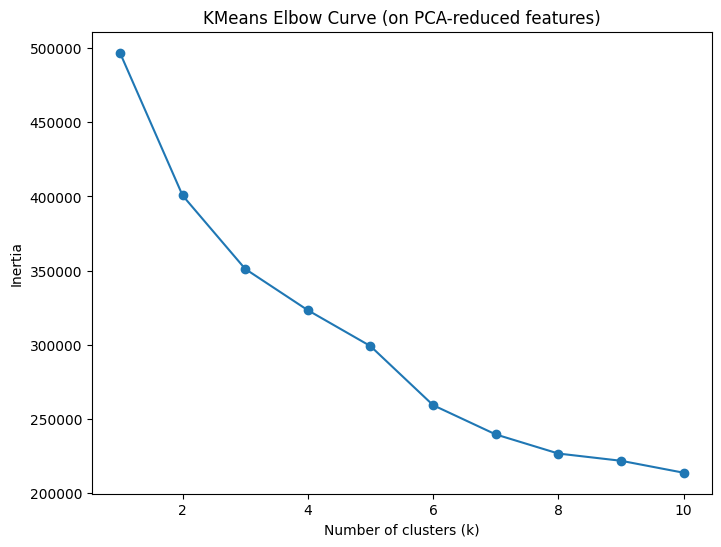

In [47]:
X_std = StandardScaler().fit_transform(df[features])

pca = PCA(n_components=8).fit(X_std)
X_pca = pca.transform(X_std)

inertias = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto").fit(X_pca)
    inertias.append(kmeans.inertia_)

# 4. Elbow plot
plt.figure(figsize=(8,6))
plt.plot(K, inertias, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("KMeans Elbow Curve (on PCA-reduced features)")
plt.show()

In [48]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init="auto").fit(X_pca)
df["cluster"] = kmeans.labels_
df.groupby("cluster")[features].mean()

,duration,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
cluster,,,,,,,,,,
0,215852.381903,0.695911,0.734383,-6.412718,0.088582,0.171452,0.086574,0.177672,0.666113,120.843311
1,257632.758959,0.457173,0.831890,-5.768414,0.086468,0.056609,0.237199,0.250780,0.298519,136.269606
2,200653.757636,0.407949,0.186196,-19.795184,0.048979,0.838479,0.792211,0.139821,0.243371,108.852900
3,221122.688831,0.558809,0.433728,-10.332685,0.145843,0.631508,0.032163,0.240929,0.389679,111.766093


In [49]:
pd.crosstab(df["cluster"], df["track_genre"])

track_genre,acoustic,afrobeat,alt-rock,alternative,ambient,anime,black-metal,bluegrass,blues,brazil,...,grindcore,groove,grunge,guitar,happy,hard-rock,hardcore,hardstyle,heavy-metal,hip-hop
cluster,,,,,,,,,,,,,,,,,,,,,
0,228,752,476,491,18,345,15,401,461,366,...,14,441,226,154,150,381,413,144,126,772
1,103,104,411,357,93,374,950,95,158,295,...,976,446,707,43,845,538,549,856,852,82
2,46,18,5,2,719,192,24,63,20,2,...,4,2,3,532,3,1,2,0,5,0
3,623,126,108,150,170,89,11,441,361,337,...,6,111,64,271,2,80,36,0,17,146


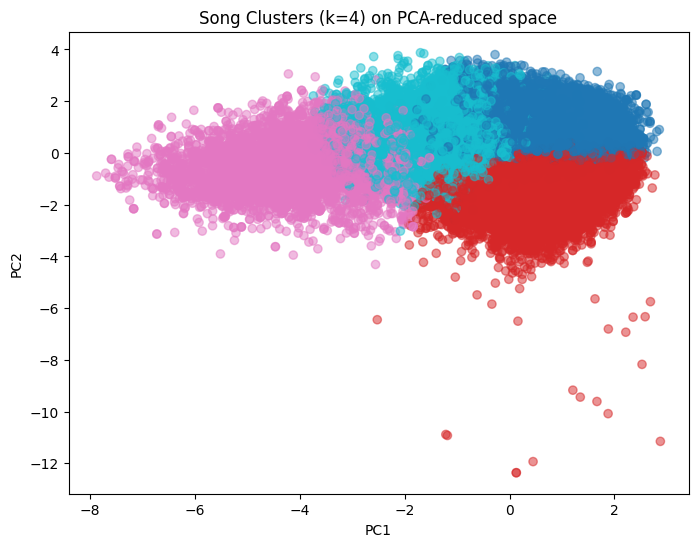

In [50]:
X_pca2 = pca.transform(X_std)[:, :2]  # first 2 PCs
plt.figure(figsize=(8,6))
plt.scatter(X_pca2[:,0], X_pca2[:,1], c=df["cluster"], cmap="tab10", alpha=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Song Clusters (k=4) on PCA-reduced space")
plt.show()


### Predicting a song in major or minor key from valence

In [38]:
X = df[['valence']]
y = df['mode']

# Inspect original class balance
unique, counts = np.unique(y, return_counts=True)
print("Original class distribution (mode):", dict(zip(unique, counts)))

# Build a balanced dataset by upsampling the minority class
df_bal = df[['valence', 'mode']].copy()
df_major = df_bal[df_bal['mode'] == 1]
df_minor = df_bal[df_bal['mode'] == 0]

if len(df_major) > len(df_minor):
    df_minor_up = resample(
        df_minor, replace=True, n_samples=len(df_major), random_state=42
    )
    df_bal = pd.concat([df_major, df_minor_up], ignore_index=True)
else:
    df_major_up = resample(
        df_major, replace=True, n_samples=len(df_minor), random_state=42
    )
    df_bal = pd.concat([df_minor, df_major_up], ignore_index=True)

# Train/Test split (stratified on the balanced labels)
X_bal = df_bal[['valence']].values
y_bal = df_bal['mode'].values
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.3, random_state=42, stratify=y_bal
)

# Fit logistic regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

y_proba = log_reg.predict_proba(X_test)[:, 1]
y_pred  = log_reg.predict(X_test)

auc = roc_auc_score(y_test, y_proba)
acc = accuracy_score(y_test, y_pred)
cm  = confusion_matrix(y_test, y_pred)

print(f"\nLogistic Regression (balanced) — Valence → Mode")
print(f"AUC:       {auc:.4f}")
print(f"Accuracy:  {acc:.4f}")
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))

Original class distribution (mode): {0: 19609, 1: 32391}

Logistic Regression (balanced) — Valence → Mode
AUC:       0.5082
Accuracy:  0.4977
Confusion Matrix:
 [[5044 4674]
 [5088 4629]]

Classification Report:
               precision    recall  f1-score   support

           0     0.4978    0.5190    0.5082      9718
           1     0.4976    0.4764    0.4868      9717

    accuracy                         0.4977     19435
   macro avg     0.4977    0.4977    0.4975     19435
weighted avg     0.4977    0.4977    0.4975     19435



In [41]:
genre_encoder = LabelEncoder()
df["genre_label"] = genre_encoder.fit_transform(df["track_genre"])

X = df[features]
y = df["genre_label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state, stratify=y
)

clf = DecisionTreeClassifier(random_state=rand_state)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Decision Tree Model Accuracy:", acc)

y_proba = clf.predict_proba(X_test)
auc_macro = roc_auc_score(y_test, y_proba, multi_class="ovr", average="macro")
print("Macro AUC (OVR):", auc_macro)

auc_weighted = roc_auc_score(y_test, y_proba, multi_class="ovr", average="weighted")
print("Weighted AUC (OVR):", auc_weighted)

Decision Tree Model Accuracy: 0.24884615384615386
Macro AUC (OVR): 0.6380730392156863
Weighted AUC (OVR): 0.6380730392156864
